# Introduction
- Dataset showcases diffrent diamonds on the market offering each diamonds attribute
- price : diamond price in US dollars from 326 to 18,823
- carat : weight of the diamond (0.2--5.01)
- cut :  quality of the cut (Fair, Good, Very Good, Premium, Ideal)
- color : diamond colour, from J (worst) to D (best)
- clarity : a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
- x : length in mm (0--10)
- y : width in mm (0--58.9)
- z depth in mm (0--31.8)
- depth total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
- table width of top of diamond relative to widest point (43--95)
- Since its always hard and time draining to tell how much a diamond can be sold for and the process needs an expert using this data to train a model we can predict a diamonds price (or clarity) based on its given attributes3--95)

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from scipy.stats.mstats import normaltest
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [121]:
data = pd.read_csv("diamonds.csv")
data = data.iloc[:, 1:]

In [122]:
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [123]:
data.shape

(53940, 10)

In [124]:
data.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [125]:
data.duplicated().sum()

146

In [126]:
data.drop_duplicates(inplace=True)

In [127]:
data.duplicated().sum()

0

In [128]:
data.shape

(53794, 10)

In [129]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53794 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53794 non-null  float64
 1   cut      53794 non-null  object 
 2   color    53794 non-null  object 
 3   clarity  53794 non-null  object 
 4   depth    53794 non-null  float64
 5   table    53794 non-null  float64
 6   price    53794 non-null  int64  
 7   x        53794 non-null  float64
 8   y        53794 non-null  float64
 9   z        53794 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


## EDA

In [130]:
cat = ['cut', 'color', 'clarity']

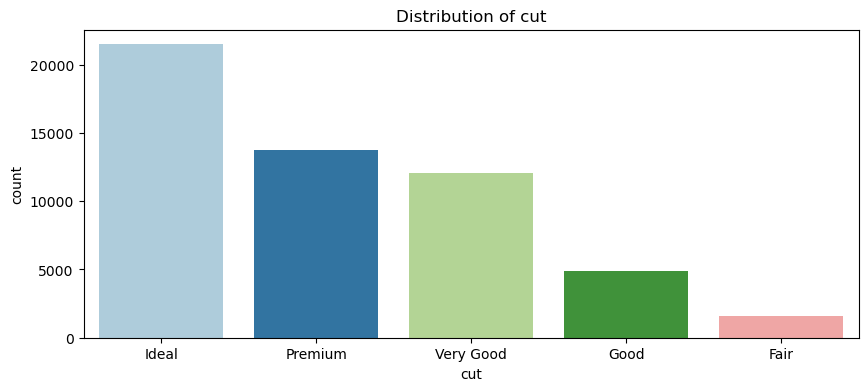

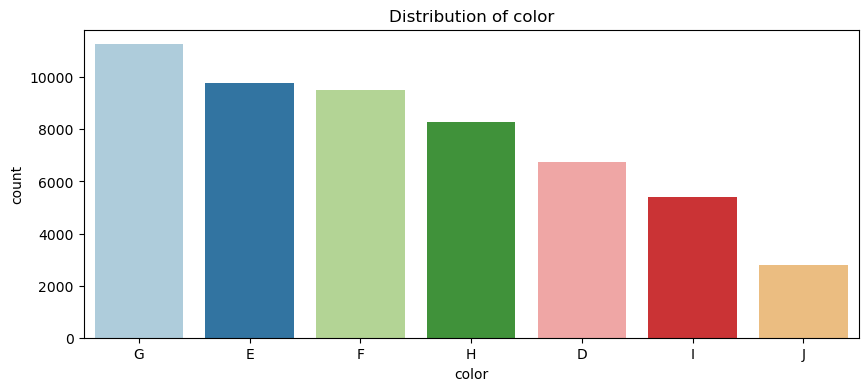

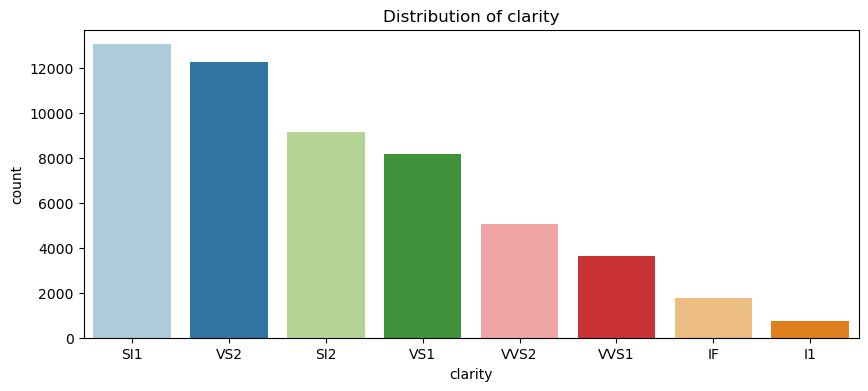

In [20]:
for col in cat:
    plt.figure(figsize=(10, 4))
    order = data[col].value_counts().index
    sns.countplot(x=col,order=order, data=data, palette = "Paired")
    plt.title(f"Distribution of {col}")
    plt.savefig(f"distribution_{col}.png", dpi=300, bbox_inches='tight')
    plt.show()

In [21]:
cut_price = data.groupby('cut')['price'].mean().sort_values(ascending=False)
cut_price

cut
Premium      4583.501891
Fair         4341.954318
Very Good    3981.016157
Good         3919.121039
Ideal        3462.749953
Name: price, dtype: float64

- Although in numbers the diamonds with an ideal cut were greater in number it seems that premium diamonds dominated in price 
- Interestigly the fair diamonds which were the lesser in count got the second place in priceing while the ideal got the last place

In [23]:
color_price = data.groupby('color')['price'].mean().sort_values(ascending=False)
color_price

color
J    5326.415418
I    5081.751248
H    4482.855174
G    4001.352069
F    3726.749580
D    3174.441007
E    3079.608020
Name: price, dtype: float64

In [24]:
color_carat = data.groupby('color')['carat'].mean().sort_values(ascending=False)
color_carat

color
J    1.162841
I    1.025197
H    0.911029
G    0.771273
F    0.736664
D    0.658315
E    0.657957
Name: carat, dtype: float64

- The worst colors starting from J tend to be used on bigger carat diamonds which explains why even though j is the worst color it has the highest price
- Similarly for D which is the best color it is usually used for smaller diamonds since they are rare and expensive which proves why they are less expensive than J diamonds

In [25]:
clarity_price = data.groupby('clarity')['price'].mean().sort_values(ascending=False)
clarity_price

clarity
SI2     5057.455410
SI1     3996.165132
VS2     3927.741516
I1      3925.275676
VS1     3841.611329
VVS2    3286.532437
IF      2870.569507
VVS1    2526.602961
Name: price, dtype: float64

In [26]:
clarity_carat = data.groupby('clarity')['carat'].mean().sort_values(ascending=False)
clarity_carat

clarity
I1      1.283527
SI2     1.076402
SI1     0.850407
VS2     0.764276
VS1     0.727436
VVS2    0.596527
IF      0.505645
VVS1    0.503696
Name: carat, dtype: float64

- Looks like the same method is used for diamiond clarity where the less clarity a diamond has the more carats it will be used for whivh upscales its price to be more dominant than IF clarity

In [29]:
cat_price = data.groupby(['color', 'clarity', 'cut'])['price'].agg(['mean', 'count']).sort_values('mean', ascending=False)
cat_price.head(5)

mean  count
color clarity cut                           
D     IF      Very Good  10298.260870     23
              Good       10030.333333      9
J     I1      Ideal       9454.000000      2
D     IF      Premium     9056.500000     10
J     SI2     Premium     7550.285714    161

In [30]:
cat_price.tail(5)

,,,mean,count
color,clarity,cut,,
E,IF,Good,1519.222222,9
I,IF,Ideal,1502.621053,95
G,IF,Fair,1488.000000,2
H,VVS1,Premium,1453.758929,112
J,IF,Very Good,1074.125000,8


-  This shows the most pricy combinations of diamond attributs D(best color), IF(best clarity), and a very good to good cut
- And The least pricey J(worst color), IF(best clarity), and a very good cut

### Descriptive Stats

In [99]:
data.describe()

,carat,depth,table,price,x,y,z
count,53794.00000,53794.000000,53794.000000,53794.000000,53794.000000,53794.000000,53794.000000
mean,0.79778,61.748080,57.458109,3933.065082,5.731214,5.734653,3.538714
std,0.47339,1.429909,2.233679,3988.114460,1.120695,1.141209,0.705037
min,0.20000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.40000,61.000000,56.000000,951.000000,4.710000,4.720000,2.910000
50%,0.70000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.04000,62.500000,59.000000,5326.750000,6.540000,6.540000,4.030000
max,5.01000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


- The price range is very varient the mean is 3900 ,the min is 300, max is 18800 (check for skewness)
- the dimentions of a diamond (x, y, z) have zero values which is impossible, there are 2 choices either drop the zero entries or be content with the depth feature which is derived from x, y, z
- Since we plan to use linear, ridge, lasso, elasticnet models which penalize large features , scalling the features is required to get them in a close range

## Linearity Assumption

- one of the assumptions of linear regression that the features have a linear relation with the target variable 

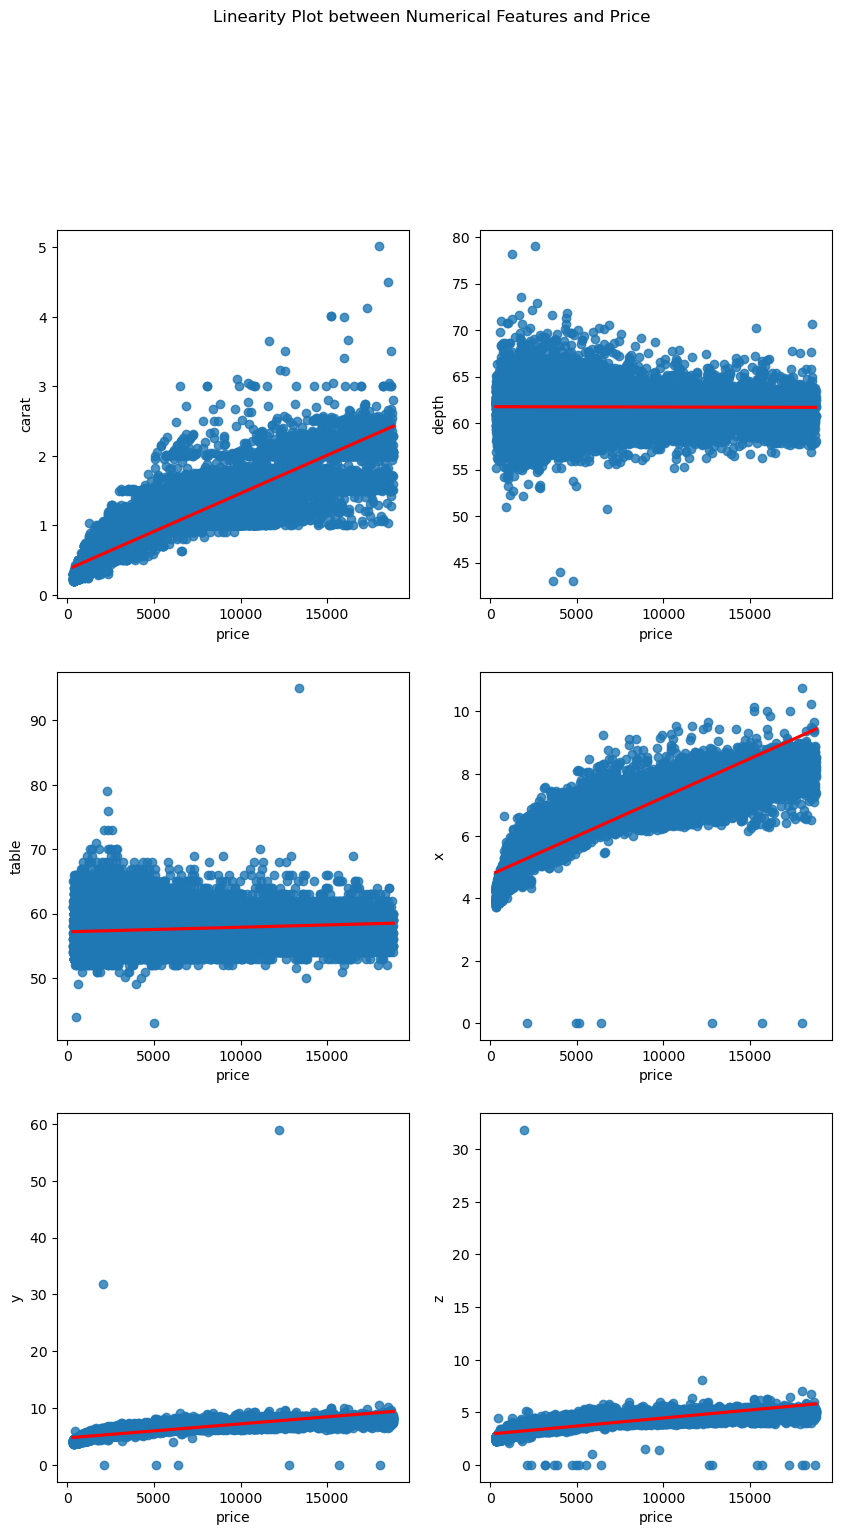

In [35]:
plt.figure(figsize = (10,22))
plt.subplot(4,2,1)
sns.regplot( x = 'price', y = 'carat',  fit_reg= True, line_kws=dict(color="r"), data=data)
plt.subplot(4,2,2)
sns.regplot( x = 'price',y = 'depth', fit_reg= True,line_kws=dict(color="r"), data=data)
plt.subplot(4,2,3)
sns.regplot( x = 'price', y = 'table', fit_reg= True,line_kws=dict(color="r"), data=data)
plt.subplot(4,2,4)
sns.regplot( x = 'price',y = 'x', fit_reg= True,line_kws=dict(color="r"), data=data)
plt.subplot(4,2,5)
sns.regplot( x = 'price',y = 'y',  fit_reg= True,line_kws=dict(color="r"),data=data)
plt.subplot(4,2,6)
sns.regplot( x = 'price',y = 'z', fit_reg= True,line_kws=dict(color="r"), data=data)

plt.suptitle("Linearity Plot between Numerical Features and Price")
plt.savefig(f"Linearity_Assumption.png", dpi=300, bbox_inches='tight')
plt.show()

- carat and x seems to have strong positive correlation but with some outliers and a strong linear relation
- depth and table dont seem to have an effect on the price and it seems to have a dense range
- the y and z seem to have small positive correlation but uts affected by the outliers so we will remove them

In [131]:
((data['x'] == 0) | (data['y'] == 0) | (data['z'] == 0)).sum()

19

In [132]:
print(f"Its impossible for a diamond to have a 3d dimention containing zeros so its a possible entry error \nthere are : {((data['x'] == 0) | (data['y'] == 0) | (data['z'] == 0)).sum()} records with entry errors for dimetions ")

Its impossible for a diamond to have a 3d dimention containing zeros so its a possible entry error 
there are : 19 records with entry errors for dimetions 


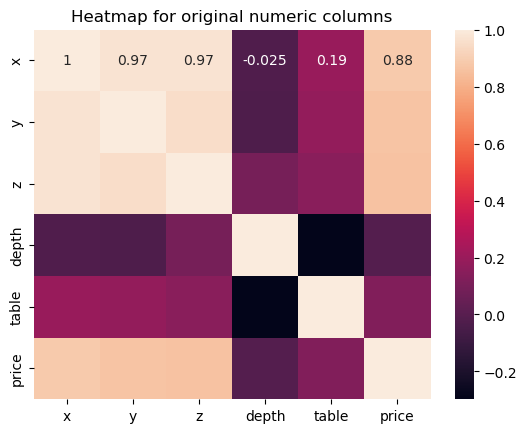

In [38]:
sns.heatmap(data[['x', 'y', 'z', 'depth','table', 'price']].corr(), annot=True)
plt.title("Heatmap for original numeric columns")
plt.savefig(f"NumericOrginHeatmaop.png", dpi=300, bbox_inches='tight')
plt.show()

- It seems that from the lenearity test (carat, x, y, z) seems to have a linear relation with the target feature
- But the dimentions x, y, z have zero values which appear as outliers
- The depth and table features shows no linear trend 
- The depth have no correlation with the target feature , so it would be best to remove the depth column and replace it with the x,y,z dimensions after cleaning the entry errors
- the table will left for now till proves somthing
- there are some point outliers that may effect my model so i will drop them

In [133]:
test_data = data.copy()

In [134]:
data.drop(columns = 'depth', inplace = True)

In [135]:
data = data[(data['x']>0) & (data['y']>0) & (data['z']>0)]

In [136]:
data = data[(data['table']<75) & (data['table']>45)]
data = data[(data['y']<30)]
data = data[(data['z']<30)]

In [137]:
data.shape

(53767, 9)

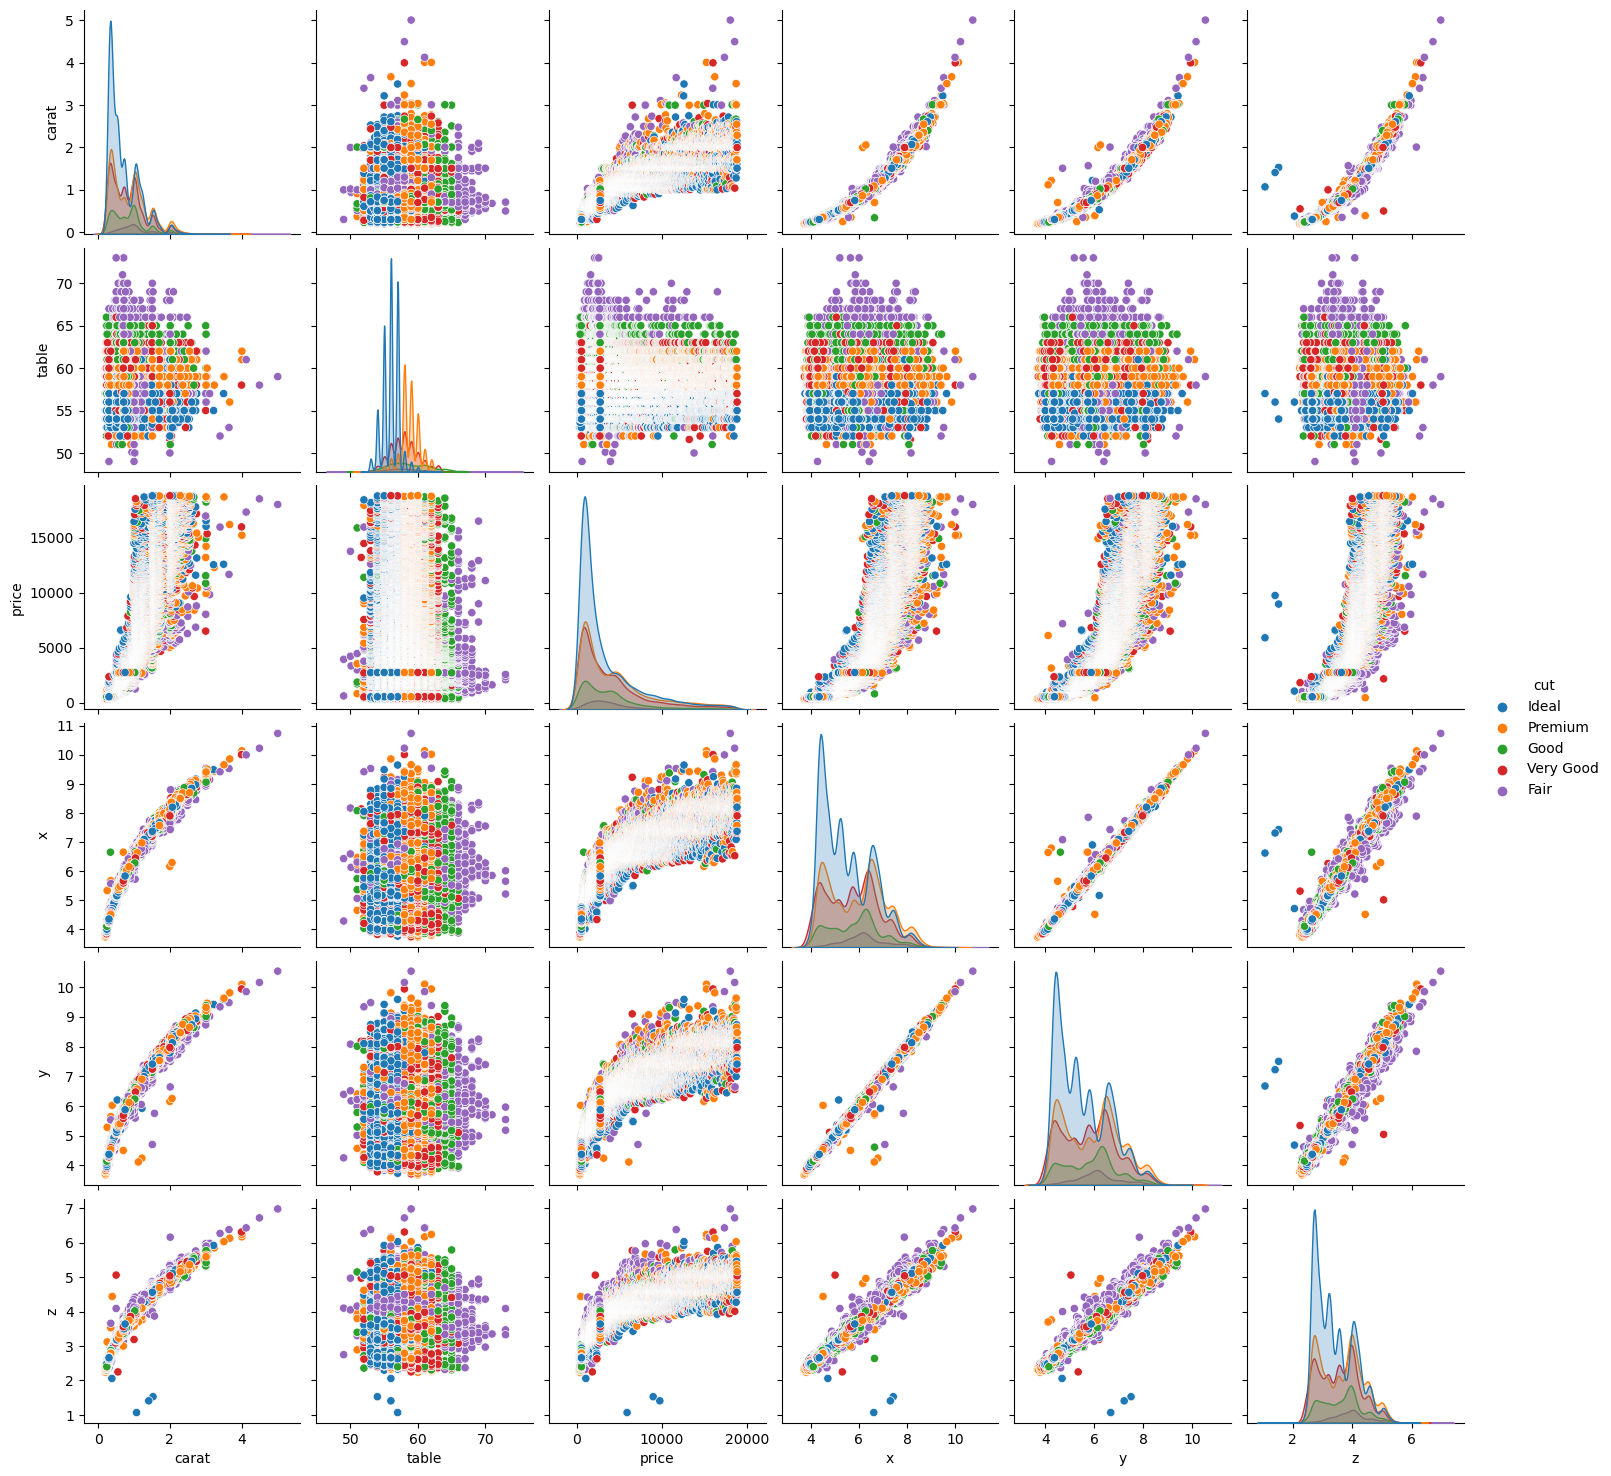

In [44]:
sns.pairplot(data, hue="cut")
plt.savefig(f"Pairplot.png", dpi=300, bbox_inches='tight')

## Target Normallity

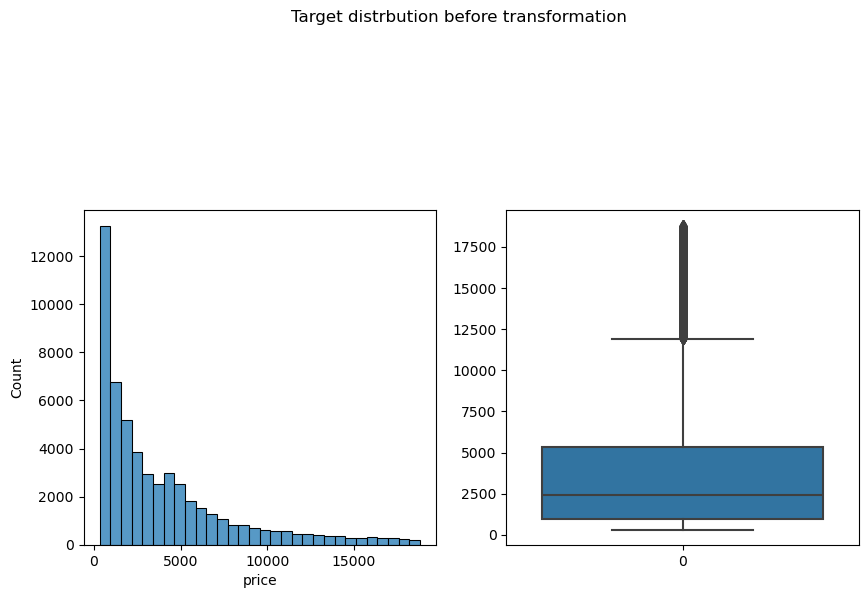

In [113]:
plt.figure(figsize = (10,20))
plt.subplot(4,2,1)
sns.histplot(data['price'], bins = 30)
plt.subplot(4,2,2)
sns.boxplot(data['price'])
plt.suptitle("Target distrbution before transformation")
plt.savefig(f"Target_before.png", dpi=300, bbox_inches='tight')

In [30]:
print(f"Original price : {normaltest(data['price'])}\nskwewness : {data['price'].skew()}")

Original price : NormaltestResult(statistic=15050.896567625456, pvalue=0.0)
skwewness : 1.6183411471551872


- The price is highly left skewed showing that most diamonds has a price range from 10-2500 (low end)
- And the pvalue of the normality test is less that 0.05
- we cant let this off since the assumptions of linear regression states that the target variable must be normally distributed
- I will try using transformations to turn the price into normal distribution


### Log transformation

In [114]:
test_data['log_price'] = np.log(test_data['price'])

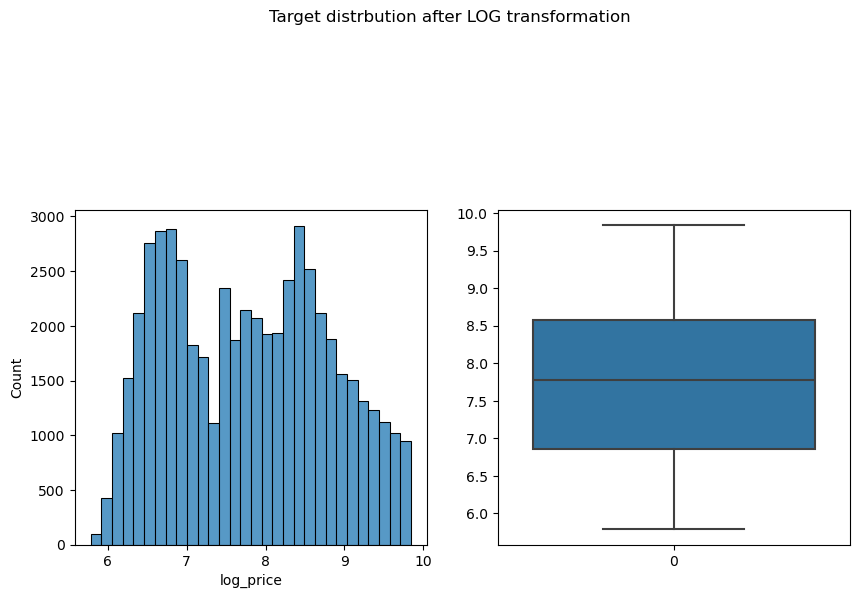

In [115]:
plt.figure(figsize = (10,20))
plt.subplot(4,2,1)
sns.histplot(test_data['log_price'], bins = 30)
plt.subplot(4,2,2)
sns.boxplot(test_data['log_price'])
plt.suptitle("Target distrbution after LOG transformation")
plt.savefig(f"Target_log.png", dpi=300, bbox_inches='tight')

In [116]:
print(f"log trans : {normaltest(test_data['log_price'])} \nskwewness : {test_data['log_price'].skew()}")

log trans : NormaltestResult(statistic=21791.692290475225, pvalue=0.0) 
skwewness : 0.1143148388366402


### Squareroot

In [117]:
test_data['sqrt_price'] = np.sqrt(test_data['price'])

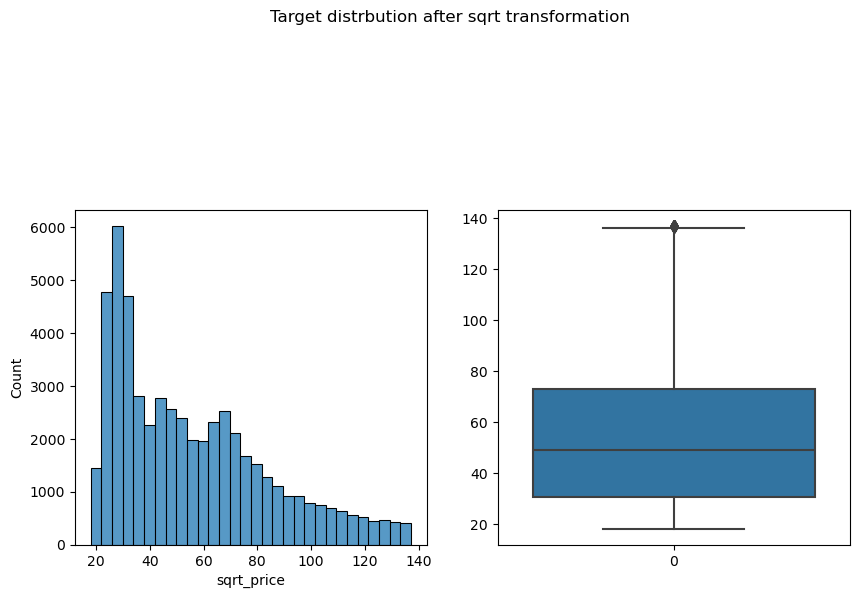

In [118]:
plt.figure(figsize = (10,20))
plt.subplot(4,2,1)
sns.histplot(test_data['sqrt_price'], bins = 30)
plt.subplot(4,2,2)
sns.boxplot(test_data['sqrt_price'])
plt.suptitle("Target distrbution after sqrt transformation")
plt.savefig(f"Target_sqrt.png", dpi=300, bbox_inches='tight')

In [36]:
print(f"sqrt trans : {normaltest(test_data['sqrt_price'])},  \nskwewness : {test_data['sqrt_price'].skew()}")

sqrt trans : NormaltestResult(statistic=4925.886954244847, pvalue=0.0),  
skwewness : 0.8438491789015818


### Boxcox

In [ ]:
boxcox_price, fitted_lambda = boxcox(test_data['price'])

In [ ]:
sns.histplot(boxcox_price)
plt.title('Box-Cox Transformed Price')
plt.savefig(f"Target_boxcox.png", dpi=300, bbox_inches='tight')
plt.show()

In [39]:
print(f"boxcox trans : {normaltest(boxcox_price)}")

boxcox trans : NormaltestResult(statistic=27202.287354862707, pvalue=0.0)


- After applying three transformations:
1. all three didnt improve the p_value but for the statistic the sqrt preformed better that log and on thisd place the boxcox
2. For the skweness the original got 1.6 and the sqrt got 0.8 which is better than the 0.11 of log (i will keep them both for trials)
- Sadly even though the price didnt become normally distributed it was imroved than first.

In [138]:
data['sqrt_price'] = np.sqrt(data['price'])
data['log_price'] = np.log(data['price'])

In [49]:
data.describe()

,carat,table,price,x,y,z,sqrt_price,log_price
count,53767.000000,53767.000000,53767.000000,53767.000000,53767.000000,53767.000000,53767.000000,53767.000000
mean,0.797507,57.456987,3931.065430,5.731537,5.733435,3.539310,55.781183,7.786721
std,0.473137,2.222482,3985.787241,1.118560,1.110468,0.691062,28.627614,1.014315
min,0.200000,49.000000,326.000000,3.730000,3.680000,1.070000,18.055470,5.786897
25%,0.400000,56.000000,951.000000,4.710000,4.720000,2.910000,30.838288,6.857514
50%,0.700000,57.000000,2401.000000,5.700000,5.710000,3.530000,49.000000,7.783641
75%,1.040000,59.000000,5324.000000,6.540000,6.540000,4.030000,72.965745,8.579980
max,5.010000,73.000000,18823.000000,10.740000,10.540000,6.980000,137.196939,9.842835


## Homoscedasticity

-  The assumption of *homoscedasticity* (constant variance), is crucial to linear regression models. *Homoscedasticity* describes a situation in which the error term or variance or the "noise" or random disturbance in the relationship between the independent variables and the dependent variable is the same across all values of the independent variable.

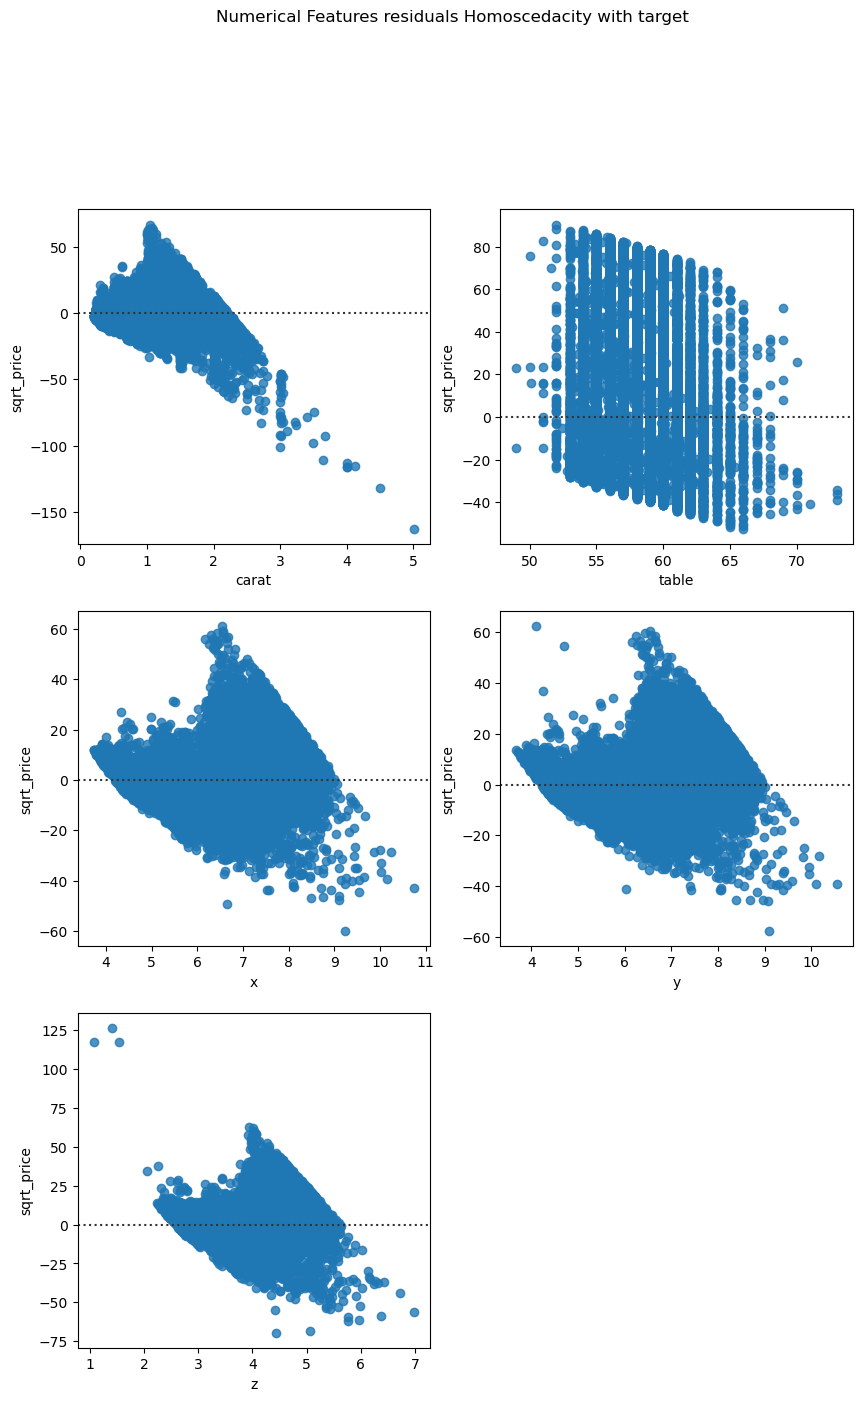

In [50]:
plt.figure(figsize = (10,20))
plt.subplot(4,2,1)
sns.residplot(x = 'carat', y = 'sqrt_price', data=data)
plt.subplot(4,2,2)
sns.residplot(x = 'table', y = 'sqrt_price', data=data)
plt.subplot(4,2,3)
sns.residplot(x = 'x', y = 'sqrt_price', data=data)
plt.subplot(4,2,4)
sns.residplot(x = 'y', y = 'sqrt_price', data=data)
plt.subplot(4,2,5)
sns.residplot(x = 'z', y = 'sqrt_price', data=data)
plt.suptitle("Numerical Features residuals Homoscedacity with target")
plt.savefig(f"Homoscedasticity.png", dpi=300, bbox_inches='tight')
plt.show()

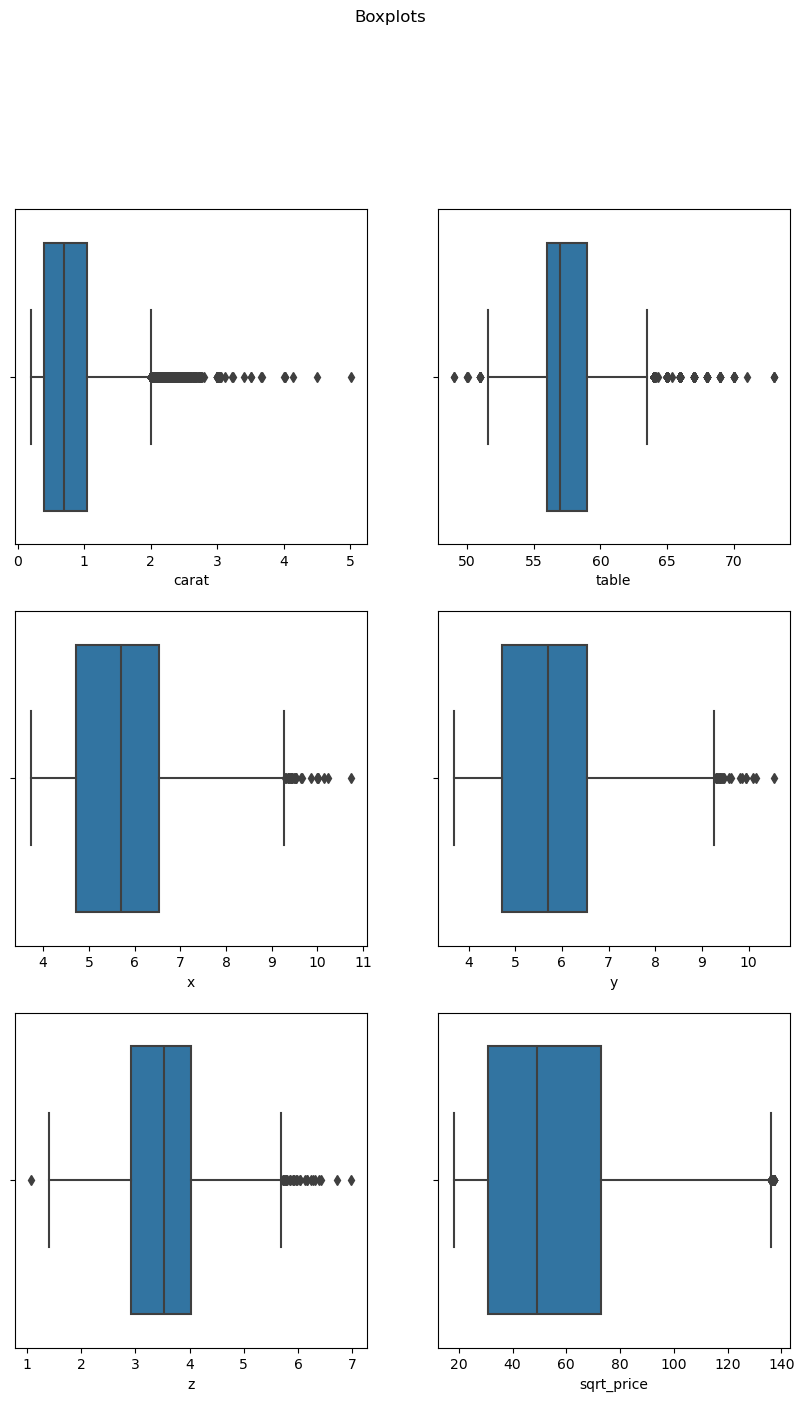

In [51]:
plt.figure(figsize = (10,20))
plt.subplot(4,2,1)
sns.boxplot(x = 'carat', data=data)
plt.subplot(4,2,2)
sns.boxplot(x = 'table',  data=data)
plt.subplot(4,2,3)
sns.boxplot(x = 'x',data=data)
plt.subplot(4,2,4)
sns.boxplot(x = 'y',data=data)
plt.subplot(4,2,5)
sns.boxplot(x = 'z', data=data)
plt.subplot(4,2,6)
sns.boxplot(x = 'sqrt_price', data=data)
plt.suptitle("Boxplots")
plt.savefig(f"Boxplots.png", dpi=300, bbox_inches='tight')
plt.show()

-  Looing at all the plots we can tell that the error variance is following a trend and not rando so the assumption of homoscendasity is not met.
- There seems to be still outliers in all numeric values so i will try to scale them using robust scaler but after the split

## MultiCollinearity

In [180]:
le = LabelEncoder()
for col in cat:
    test_data[col] = le.fit_transform(test_data[col])

In [181]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53794 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53794 non-null  float64
 1   cut      53794 non-null  int32  
 2   color    53794 non-null  int32  
 3   clarity  53794 non-null  int32  
 4   depth    53794 non-null  float64
 5   table    53794 non-null  float64
 6   price    53794 non-null  int64  
 7   x        53794 non-null  float64
 8   y        53794 non-null  float64
 9   z        53794 non-null  float64
dtypes: float64(6), int32(3), int64(1)
memory usage: 3.9 MB


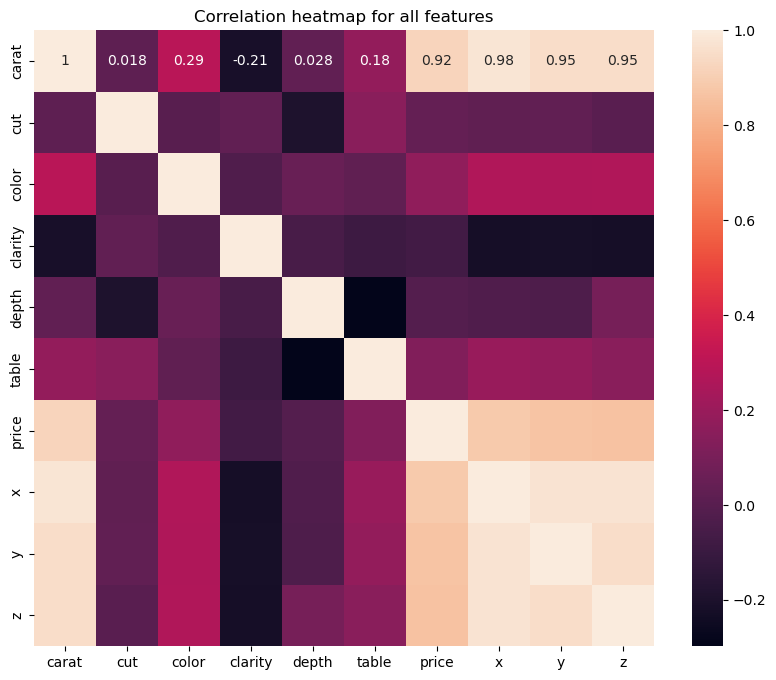

In [182]:
plt.figure(figsize = (10,8))
sns.heatmap(test_data.corr(), annot = True)
plt.title("Correlation heatmap for all features")
plt.savefig(f"all_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

- There exists MultiCollinearity , But since we already dropped one feature (depth in original data)it is best to hold of on dropping the other
- clarity and cut have low correlation with target variable
- Uisng Ridge, lasso and elastic net can help in shrinking and eliminationg some correlated variables

# Data Modeling

In [183]:
X_encoded = pd.get_dummies(data.drop(columns=['sqrt_price', 'log_price', 'price']), drop_first=True)
y = data['log_price'] # After trying sqrtprice => on avarage 96% accuracy, and without transformation 92% accuracy

In [184]:
X_encoded.columns

Index(['carat', 'table', 'x', 'y', 'z', 'cut_Good', 'cut_Ideal', 'cut_Premium',
       'cut_Very Good', 'color_E', 'color_F', 'color_G', 'color_H', 'color_I',
       'color_J', 'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1',
       'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2'],
      dtype='object')

In [185]:
X_train, X_test, y_train, y_test = train_test_split(
   X_encoded, y, test_size=0.3, random_state=42)

In [186]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [187]:
results = []

In [188]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    
    model.fit(X_train, y_train)
    
    #Prediction
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Training Outcomes
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mse_train)
    r2_train = r2_score(y_train, y_train_pred)
    r2_adj_train = 1 - (1 - r2_train) * (len(y_train) - 1) / (len(y_train) - X_train.shape[1] - 1)

    # Testing Outcomes
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test, y_test_pred)
    r2_adj_test = 1 - (1 - r2_test) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

    results.append({
        'Model_name': name,
        'Model' : model,
        'train_mse': mse_train,
        'train_rmse': rmse_train,
        'train_R²': r2_train,
        'train_R²_Adj': r2_adj_train,
        'test_mse': mse_test, 
        'testrmse': rmse_test,
        'test_R²': r2_test,
        'test_R²_Adj': r2_adj_test,
        'y_test_pred': y_test_pred
    })

    print(f"{name} Results:")
    print(f"Train => MSE: {mse_train:.4f}, RMSE: {rmse_train:.4f}, R²: {r2_train:.4f}, R²_adj: {r2_adj_train:.4f}")
    print(f"Test  => MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}, R²: {r2_test:.4f}, R²_adj: {r2_adj_test:.4f}\n")

## Linear Regression Assumptions
- Handel outliers (amputated some and handeled the rest using robust scaler)
- Normaility (I used transformation on price the best one was sqrt , log, boxcox)
- linear realtion ships (removed depth)
- Encoded categorical variables

In [189]:
lr = LinearRegression()
evaluate_model("Linear Regression (No regularization)", lr, X_train_scaled, y_train, X_test_scaled, y_test)

Linear Regression (No regularization) Results:
Train => MSE: 0.0187, RMSE: 0.1366, R²: 0.9820, R²_adj: 0.9820
Test  => MSE: 0.0184, RMSE: 0.1357, R²: 0.9819, R²_adj: 0.9818



## Ridge Regression

- 
- Helps with Multicollinearity 

In [190]:
ridge = Ridge()
evaluate_model("Ridge Regression", ridge, X_train_scaled, y_train, X_test_scaled, y_test)

Ridge Regression Results:
Train => MSE: 0.0187, RMSE: 0.1366, R²: 0.9820, R²_adj: 0.9820
Test  => MSE: 0.0184, RMSE: 0.1358, R²: 0.9819, R²_adj: 0.9818



## Lasso Regression

In [191]:
lasso = Lasso()
evaluate_model("Lasso Regression", lasso, X_train_scaled, y_train, X_test_scaled, y_test)

Lasso Regression Results:
Train => MSE: 1.0343, RMSE: 1.0170, R²: 0.0000, R²_adj: -0.0006
Test  => MSE: 1.0160, RMSE: 1.0080, R²: -0.0000, R²_adj: -0.0014



- it seems that the lasso penelized the cofficients too much that it zeroed all the features,
- This happenned because the alpha was too big

In [192]:
alphas = [0.0001,0.0005, 0.001, 0.01, 0.1, 1]

In [193]:
for a in alphas:
    lasso = Lasso(alpha=a)
    lasso.fit(X_train_scaled, y_train)
    y_pred = lasso.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Alpha: {a}")
    zeroed = np.sum((lasso.coef_)==0)
    print(f"zero coefficients: {zeroed}")
    print(f"R²: {r2:.4f}")

Alpha: 0.0001
zero coefficients: 0
R²: 0.9818
Alpha: 0.0005
zero coefficients: 0
R²: 0.9805
Alpha: 0.001
zero coefficients: 2
R²: 0.9782
Alpha: 0.01
zero coefficients: 11
R²: 0.9476
Alpha: 0.1
zero coefficients: 18
R²: 0.8946
Alpha: 1
zero coefficients: 22
R²: -0.0000


- It seems the best accuracy is when using all the features together but from this experiment the larger the alpha is the more penality is added the more coefficienrs are lost

In [194]:
lasso_tuned = Lasso(alpha = 0.0001)
evaluate_model("Lasso Regression (Tuned)", lasso_tuned, X_train_scaled, y_train, X_test_scaled, y_test)

Lasso Regression (Tuned) Results:
Train => MSE: 0.0187, RMSE: 0.1368, R²: 0.9819, R²_adj: 0.9819
Test  => MSE: 0.0185, RMSE: 0.1360, R²: 0.9818, R²_adj: 0.9818



## Elastic Net

In [195]:
elastic = ElasticNet()
evaluate_model("ElasticNet", elastic, X_train_scaled, y_train, X_test_scaled, y_test)

ElasticNet Results:
Train => MSE: 0.7686, RMSE: 0.8767, R²: 0.2569, R²_adj: 0.2564
Test  => MSE: 0.7568, RMSE: 0.8699, R²: 0.2551, R²_adj: 0.2541



- same here it shrunk the officients too much

In [196]:
for a in alphas:
    elastic = ElasticNet(alpha=a)
    elastic.fit(X_train_scaled, y_train)
    y_pred = elastic.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Alpha: {a}")
    zeroed = np.sum((elastic.coef_)==0)
    print(f"zero coefficients: {zeroed}")
    print(f"R²: {r2:.4f}")

Alpha: 0.0001
zero coefficients: 0
R²: 0.9818
Alpha: 0.0005
zero coefficients: 0
R²: 0.9810
Alpha: 0.001
zero coefficients: 0
R²: 0.9792
Alpha: 0.01
zero coefficients: 6
R²: 0.9576
Alpha: 0.1
zero coefficients: 18
R²: 0.9036
Alpha: 1
zero coefficients: 18
R²: 0.2551


- since the elastic mixes both approaches it seems that its more lineint in penelizing 
- I think at first the accuracy decreased a bit because it shrinked the coefficients and after 3 trials it started canceling features

In [197]:
elastic_tuned = ElasticNet(alpha = 0.0001)

In [198]:
evaluate_model("ElasticNet (Tuned)", elastic_tuned, X_train_scaled, y_train, X_test_scaled, y_test)

ElasticNet (Tuned) Results:
Train => MSE: 0.0187, RMSE: 0.1367, R²: 0.9819, R²_adj: 0.9819
Test  => MSE: 0.0185, RMSE: 0.1359, R²: 0.9818, R²_adj: 0.9818



In [199]:
df_results = pd.DataFrame(results)
df_results

,Model_name,Model,train_mse,train_rmse,train_R²,train_R²_Adj,test_mse,testrmse,test_R²,test_R²_Adj,y_test_pred
0,Linear Regression (No regularization),LinearRegression(),0.018655,0.136584,0.981964,0.981953,0.018414,0.135700,0.981875,0.981850,"[8.169040706300894, 8.09069809011415, 8.582582..."
1,Ridge Regression,Ridge(),0.018658,0.136593,0.981962,0.981951,0.018428,0.135751,0.981861,0.981836,"[8.169124709164025, 8.09017386311967, 8.582623..."
2,Lasso Regression,Lasso(),1.034322,1.017016,0.000000,-0.000585,1.015981,1.007959,-0.000038,-0.001404,"[7.788593062032066, 7.788593062032066, 7.78859..."
3,Lasso Regression (Tuned),Lasso(alpha=0.0001),0.018702,0.136757,0.981918,0.981908,0.018493,0.135987,0.981798,0.981773,"[8.16778269106721, 8.0855651469009, 8.57721437..."
4,ElasticNet,ElasticNet(),0.768639,0.876721,0.256867,0.256432,0.756773,0.869927,0.255102,0.254085,"[7.782271416835125, 7.762703367750891, 7.86025..."
5,ElasticNet (Tuned),ElasticNet(alpha=0.0001),0.018689,0.136707,0.981931,0.981921,0.018481,0.135945,0.981809,0.981784,"[8.168280967640975, 8.087314505170102, 8.57930..."


### Actual VS Predicted Prices

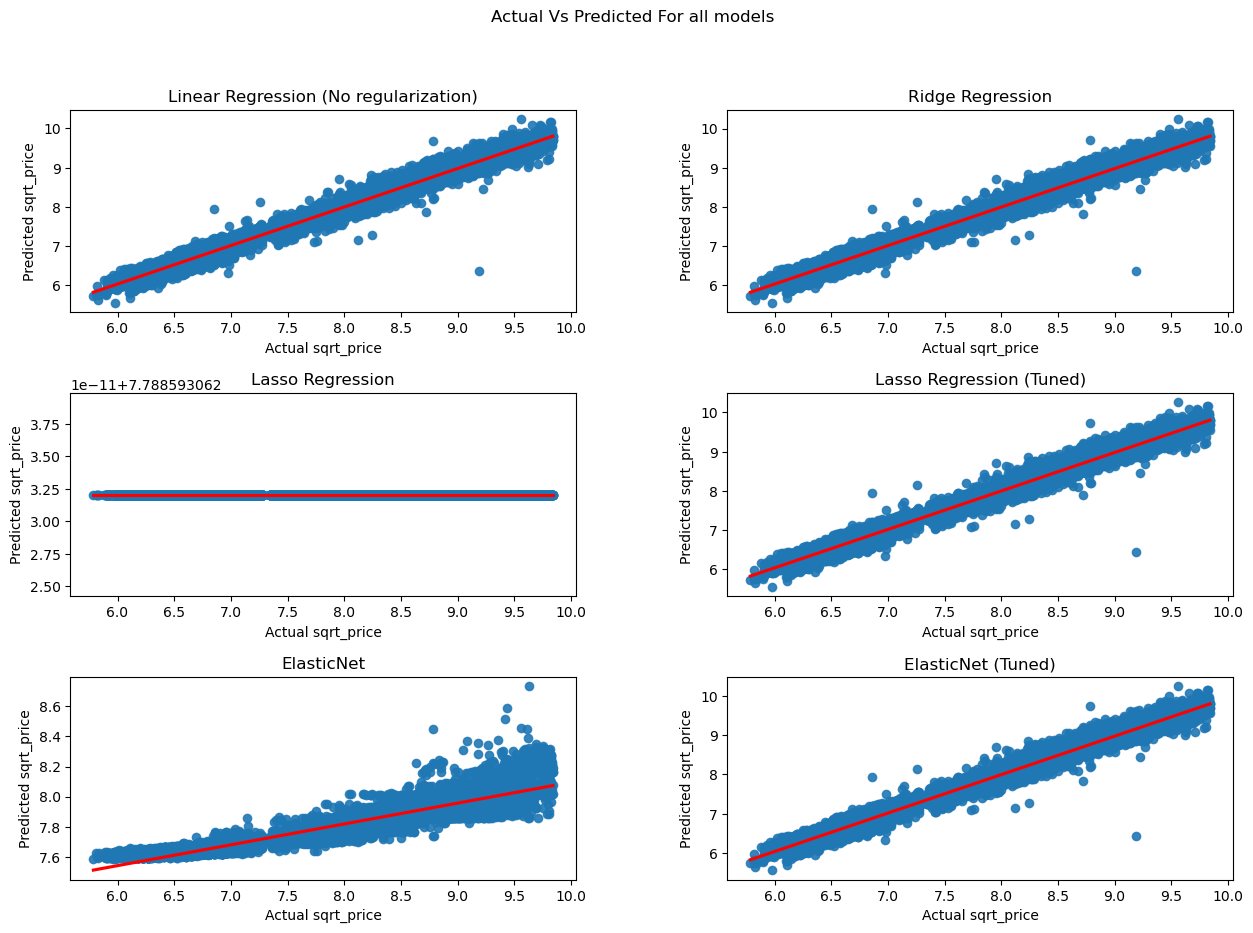

In [202]:
plt.figure(figsize=(15, 10))

for i, (index, row) in enumerate(df_results.iterrows()):
    y_test_pred = row['y_test_pred']
    name = row['Model_name']
    
    plt.subplot(3, 2, i+1)
    sns.scatterplot(x = y_test, y=y_test_pred, alpha=0.5)
    sns.regplot(x = y_test, y = y_test_pred , line_kws =dict(color="r"))
    plt.xlabel("Actual sqrt_price")
    plt.ylabel("Predicted sqrt_price")
    plt.title(f"{name}")
    
plt.subplots_adjust(hspace=0.4, wspace=0.3)    
plt.suptitle('Actual Vs Predicted For all models')
plt.savefig(f"ActualVsPredict.png", dpi=300, bbox_inches='tight')
plt.show()

## Getting the cofficients

In [203]:
coeff = {}

In [204]:
for i, row in df_results.iterrows():
    model = row['Model_name']
    estimator = row['Model']
    coeff[model] = estimator.coef_

In [205]:
features = X_train.columns
features

Index(['carat', 'table', 'x', 'y', 'z', 'cut_Good', 'cut_Ideal', 'cut_Premium',
       'cut_Very Good', 'color_E', 'color_F', 'color_G', 'color_H', 'color_I',
       'color_J', 'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1',
       'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2'],
      dtype='object')

In [206]:
coeff_df = pd.DataFrame(coeff, index = features)
coeff_df

,Linear Regression (No regularization),Ridge Regression,Lasso Regression,Lasso Regression (Tuned),ElasticNet,ElasticNet (Tuned)
carat,-0.650352,-0.648491,0.0,-0.644159,0.164841,-0.644332
table,0.024017,0.023898,0.0,0.022315,0.000000,0.022817
x,1.101629,1.075161,0.0,1.124925,0.020043,1.086057
y,0.353756,0.381271,0.0,0.347118,0.019426,0.382376
z,1.097578,1.093784,0.0,1.071006,0.010075,1.075172
cut_Good,0.068053,0.067677,0.0,0.057636,0.000000,0.062650
cut_Ideal,0.127861,0.127541,-0.0,0.116676,-0.000000,0.121937
cut_Premium,0.101289,0.101458,0.0,0.090095,0.000000,0.095889
cut_Very Good,0.093177,0.092613,0.0,0.083134,0.000000,0.087699
color_E,-0.057902,-0.057595,-0.0,-0.052668,-0.000000,-0.054719


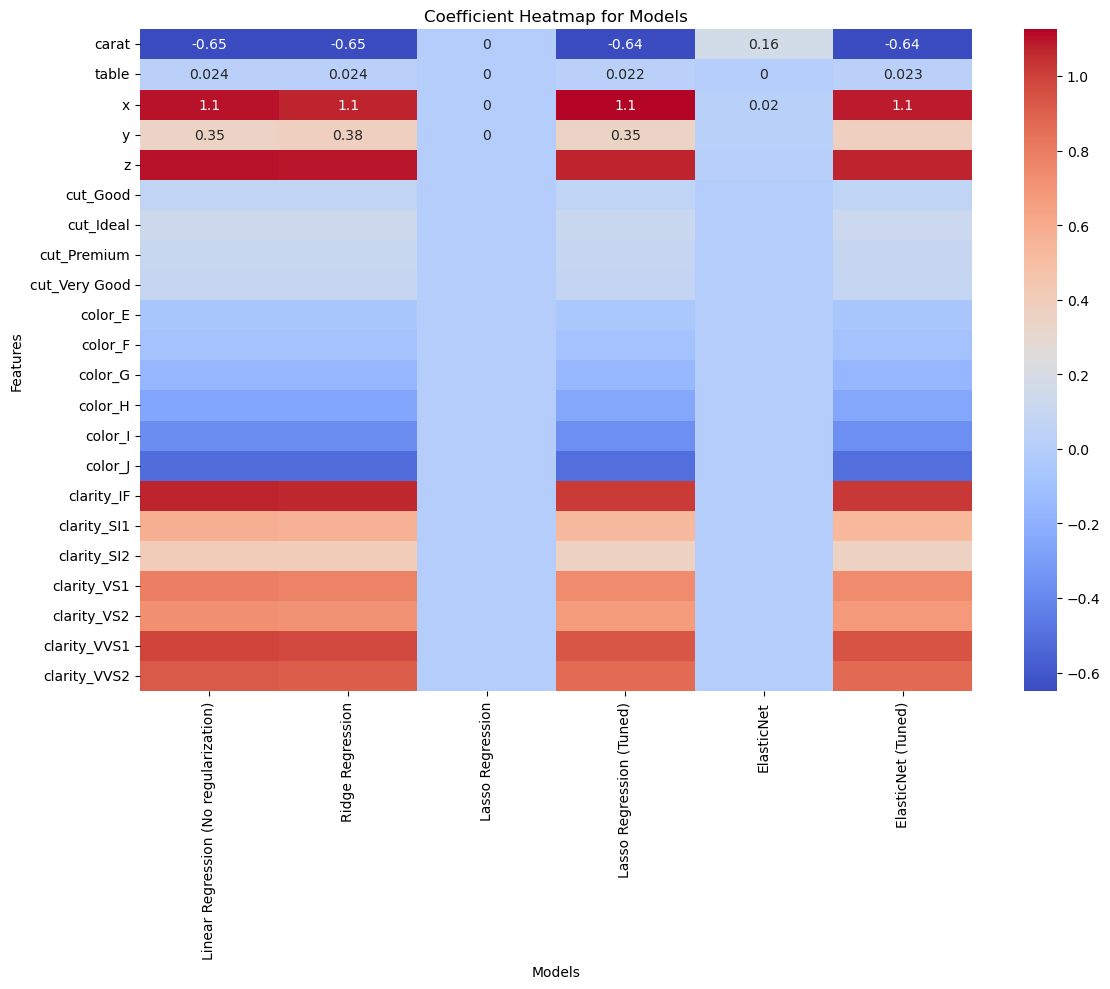

In [207]:
plt.figure(figsize=(12, 10))
sns.heatmap(coeff_df, annot=True,cmap='coolwarm')
plt.title("Coefficient Heatmap for Models")
plt.ylabel("Features")
plt.xlabel("Models")
plt.savefig(f"Cofficient_Heatmap.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [208]:
zeroed= (coeff_df == 0).sum().sort_values()

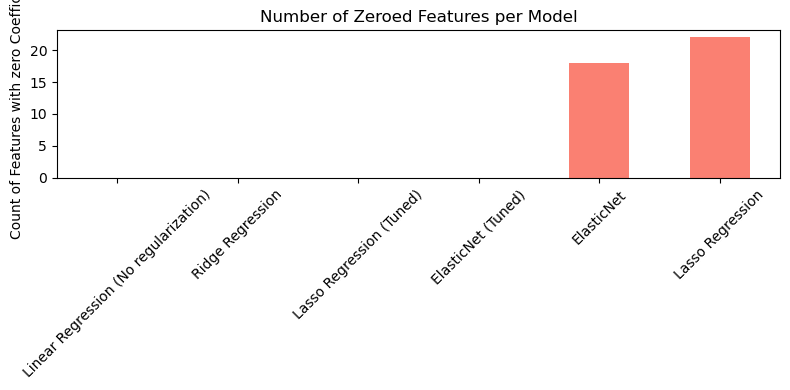

In [209]:
plt.figure(figsize=(8, 4))
zeroed.plot(kind='bar', color='salmon')
plt.title("Number of Zeroed Features per Model")
plt.ylabel("Count of Features with zero Coefficient")
plt.xticks(rotation=45)
plt.savefig(f"zero_coef_count.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

### In Conclusion
- There seemed to be duplicated diamonds, zero dimention entries, some one points outliers that were removed
- Through vid=sualizations and summerization statistics the carat attribute seemed to contribute heavily to a price of a diamond, while depth and table seemed to not have a big effect on the price
- Since the depth was calculated through x, y, z (dims) i removed it and kept the table
- the target column didnt achieve normality in distribution after trying many transformations the best were log and sqrt transformation so it depended on the model accuracy
- The Linearity was achieved for all features
- the multicolinearity wasnt achieved probably due to outliers so it was left for the robust scaler and the ridge to penelize it.
- For the data modeling the best models preformance were Linear Regression (test RMSE=0.1357, testR2= 0.9819), Ridge, lasso tuned, elestic net tuned all got similar metrics to the linear regression only the lass tuned got a better RMSE = -.1360
